<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h1>CLASSIFICATION MODEL DEVELOPMENT</h1>
<br>PREDICTING WHETHER CHARACTERS OF GAME OF THRONES ARE ALIVE<br>
<br>Machine Learning
<br>William Laverde - BMBAN1
<br>Hult International Business School<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

The goal is to create a model that predicts whether a character from the hit series, Game of Thrones,<br>
is alive at the end of the story, based on a dataset with the characters mentioned across the books <br>
of the saga, along with some information that we know based on the first five books.

<br>For this, I will be analyzing the dataset, treating missing values, engineering features based on the <br> observations, and using the most relevant and impactful ones to create different prediction models<br>
that maximize the area under the ROC curve. 

<br>At the end, the best model for the prediction will be selected through comparison, based on metrics<br>
such as accuracy, precision, recall and specificity.

<br>These indicators are calculated based on a Confusion Matrix derived from the results of the model.<br>
In this case, the confusion matrix will be read in the following way:
<br>

~~~

  TRUE NEGATIVE                              |  FALSE POSITIVE
  PREDICTED: IS NOT ALIVE (isAlive = 0)      |  PREDICTED: IS ALIVE (isAlive = 1)
  ACTUAL:    IS NOT ALIVE (isAlive = 0)      |  ACTUAL:    IS NOT ALIVE (isAlive = 0)
                                             |
---------------------------------------------|-----------------------------------------
                                             |
  FALSE NEGATIVE                             |  TRUE POSITIVE
  PREDICTED: IS NOT ALIVE (isAlive = 0)      |  PREDICTED: IS ALIVE (isAlive = 1)
  ACTUAL:    IS ALIVE (isAlive = 1)          |  ACTUAL:    IS ALIVE (isAlive = 1)
                                             |  
~~~


In [46]:
#importing all the required libraries
import pandas            as pd                          # data science essentials
import matplotlib.pyplot as plt                         # data visualization
import seaborn           as sns                         # enhanced data viz
from sklearn.model_selection import train_test_split    # train-test split
from sklearn.linear_model import LogisticRegression     # logistic regression
import statsmodels.formula.api as smf                   # logistic regression
from sklearn.metrics import confusion_matrix            # confusion matrix
from sklearn.metrics import roc_auc_score               # auc score
from sklearn.neighbors import KNeighborsClassifier      # KNN for classification
from sklearn.neighbors import KNeighborsRegressor       # KNN for regression
from sklearn.preprocessing import StandardScaler        # standard scaler
from sklearn.tree import DecisionTreeClassifier         # classification trees
from sklearn.tree import plot_tree                      # tree plots
import numpy as np                                      # numpy
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.metrics import make_scorer                 # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

#indicating dataset path
file = "GOT_character_predictions.xlsx"

#importing dataset
got = pd.read_excel(io = file,
                    sheet_name = 0,
                    header = 0)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

#reading the first columns
got.head(n = 10)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1
5,6,Tommen Baratheon,NaN,NaN,NaN,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,NaN,NaN,0,0,0,0,0,1.0,1.0,1.0,NaN,0,0,NaN,5,1.000000,1
6,7,Valarr Targaryen,Hand of the King,Valyrian,183.0,NaN,NaN,NaN,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,NaN,NaN,NaN,1.0,1,1,26.0,0,0.431438,0
7,8,Viserys I Targaryen,NaN,NaN,NaN,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,NaN,NaN,0,0,0,0,0,1.0,1.0,1.0,NaN,0,0,NaN,5,0.678930,0
8,9,Wilbert,Ser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.006689,0
9,10,Wilbert Osgrey,Ser,NaN,NaN,NaN,NaN,NaN,House Osgrey,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.020067,1


In [47]:
#IMPORTING FUNCTION FOR KN NEIGHBORS

#defining optimal neighbors function from Prof. Chase

def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    #optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


#defining function to visualize confusion matrix
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [48]:
#IMPORTING FUNCTION TO SEE FEATURE IMPORTANCE
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

In [49]:
#checking the dataset's shape
got.shape

(1946, 25)

In [50]:
#checking the dataset's info
got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

In [51]:
#checking for missing values
got.isnull().astype(int).sum() > 0

S.No                          False
name                          False
title                          True
culture                        True
dateOfBirth                    True
mother                         True
father                         True
heir                           True
house                          True
spouse                         True
book1_A_Game_Of_Thrones       False
book2_A_Clash_Of_Kings        False
book3_A_Storm_Of_Swords       False
book4_A_Feast_For_Crows       False
book5_A_Dance_with_Dragons    False
isAliveMother                  True
isAliveFather                  True
isAliveHeir                    True
isAliveSpouse                  True
isMarried                     False
isNoble                       False
age                            True
numDeadRelations              False
popularity                    False
isAlive                       False
dtype: bool

In [52]:
#checking for missing value counts
got.isnull().sum(axis = 0)

S.No                             0
name                             0
title                         1008
culture                       1269
dateOfBirth                   1513
mother                        1925
father                        1920
heir                          1923
house                          427
spouse                        1670
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveMother                 1925
isAliveFather                 1920
isAliveHeir                   1923
isAliveSpouse                 1670
isMarried                        0
isNoble                          0
age                           1513
numDeadRelations                 0
popularity                       0
isAlive                          0
dtype: int64

In [53]:
#dropping index column - will not be part of the final model
got.drop('S.No', inplace = True, axis = 1)

#checking results
got.head(n = 5)

,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1


In [54]:
#flagging missing values
for col in got:
            
    if got[col] .isnull() .astype(int) .sum()  > 0:
        got['m_' + col] = got[col] .isnull() .astype(int)
    
    else:
        got['m_' + col] = got[col] .isnull() .astype(int)
        
#total missing values per observation
got['mv_sum'] = got['m_title'] + got['m_culture'] + got['m_dateOfBirth'] + got['m_mother']\
              + got['m_father'] + got['m_heir'] + got['m_house'] + got['m_spouse']\
              + got['m_isAliveMother'] + got['m_isAliveFather'] +  + got['m_isAliveHeir']\
              + got['m_isAliveSpouse'] + got['m_age']

#checking results
print(f"""

Number of Missing Values per Observation (Pct)
----------------------------------------------
{(got['mv_sum'].value_counts(normalize = True,
                              sort      = True,
                              ascending = True)*100).round(2)}\n""")



Number of Missing Values per Observation (Pct)
----------------------------------------------
6      2.52
7      3.60
13     5.09
8      5.60
9      8.53
10    17.01
12    26.57
11    31.09
Name: mv_sum, dtype: float64



In [55]:
#dropping unnecessary missing value columns - none of these features have missing values
del got['mv_sum']
del got['m_isAlive']
del got['m_popularity']
del got['m_numDeadRelations']
del got['m_isMarried']
del got['m_isNoble']
del got['m_book1_A_Game_Of_Thrones']
del got['m_book2_A_Clash_Of_Kings']
del got['m_book3_A_Storm_Of_Swords']
del got['m_book4_A_Feast_For_Crows']
del got['m_book5_A_Dance_with_Dragons']
del got['m_name']
             
#checking the results
got.head(n = 10)

,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,m_title,m_culture,m_dateOfBirth,m_mother,m_father,m_heir,m_house,m_spouse,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,m_age
0,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1
1,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0
2,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1
3,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0
4,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0
5,Tommen Baratheon,NaN,NaN,NaN,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,NaN,NaN,0,0,0,0,0,1.0,1.0,1.0,NaN,0,0,NaN,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1
6,Valarr Targaryen,Hand of the King,Valyrian,183.0,NaN,NaN,NaN,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,NaN,NaN,NaN,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0
7,Viserys I Targaryen,NaN,NaN,NaN,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,NaN,NaN,0,0,0,0,0,1.0,1.0,1.0,NaN,0,0,NaN,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1
8,Wilbert,Ser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1
9,Wilbert Osgrey,Ser,NaN,NaN,NaN,NaN,NaN,House Osgrey,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1


In [56]:
#renaming columns that will be used as features - uk stands for unknown
got = got.rename(columns = {'m_title':'no_title','m_culture':'culture_uk',\
                            'm_dateOfBirth':'DoB_uk','m_mother':'moher_uk',\
                            'm_father':'father_uk','m_heir':'heir_uk',\
                            'm_spouse':'spouse_uk','m_age':'age_uk',\
                            'm_house':'house_uk'})

#checking the results
got.head(n = 5)

,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk
0,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1
1,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0
2,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1
3,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0
4,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0


In [57]:
#TREATMENT OF MISSING VALUES FOR CATEGORICAL VARIABLES
#these will just be inputed with unknown to keep the integrity of the data
got['title']         .fillna(value = 'unknown', inplace = True)
got['culture']       .fillna(value = 'unknown', inplace = True)
got['mother']        .fillna(value = 'unknown', inplace = True)
got['father']        .fillna(value = 'unknown', inplace = True)
got['heir']          .fillna(value = 'unknown', inplace = True)
got['house']         .fillna(value = 'unknown', inplace = True)
got['spouse']        .fillna(value = 'unknown', inplace = True)

#imputing dummy categoricals with zero, as they do not have a relative mentioned in the data
#these values coincide with the ones in the mother, father, heir, and spouse columns, respectively
got['isAliveMother'] .fillna(value = 0, inplace = True)
got['isAliveFather'] .fillna(value = 0, inplace = True)
got['isAliveHeir']   .fillna(value = 0, inplace = True)
got['isAliveSpouse'] .fillna(value = 0, inplace = True)

#TREATMENT OF MISSING VALUES FOR CONTINUOUS VARIABLES

#for date of birth, we will inpute with zero
#it is not a variable that will be used in the final model, measurment unit unknown
got['dateOfBirth']   .fillna(value = 0, inplace = True)

#for the age, we will inpute with the median
age_median = got['age'].median()

got['age'].fillna(value = age_median, inplace = True)

#checking results
got.head(n = 10)

,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk
0,Viserys II Targaryen,unknown,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1
1,Walder Frey,Lord of the Crossing,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0
2,Addison Hill,Ser,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1
3,Aemma Arryn,Queen,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0
4,Sylva Santagar,Greenstone,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0
5,Tommen Baratheon,unknown,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1
6,Valarr Targaryen,Hand of the King,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0
7,Viserys I Targaryen,unknown,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1
8,Wilbert,Ser,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1
9,Wilbert Osgrey,Ser,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1


In [58]:
#inverting helping column to create feature that makes sense
if 'has_title' not in got.columns:
    ttl = []  #creating helping column
    
    #creating for loop to invert column
    for i in got['no_title']:
        if i == 1:
            ttl.append(0)
        elif i == 0:
            ttl.append(1)
        else:
            ttl.append("Error")

    got.insert(loc = 2, column = 'has_title', value = ttl)  #inserting helping column to the dataset

#checking head
got.head(n = 5)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0


In [59]:
#ENGINEERING NEW COLUMNS FOR THE MAIN HOUSES

#inputing missing culture values as unknown
got['house'].fillna(value = 'unknown', inplace = True)

#creating new column for main house: Night's Watch
got['h_nightwatch'] = np.where(got['name'].str.contains("Night's Watch")|\
                              got['house'].str.contains("Night's Watch")|\
                              got['father'].str.contains("Night's Watch"),1,0)

#creating new column for main house: House Frey
got['h_frey'] = np.where(got['name'].str.contains('Frey')|\
                              got['house'].str.contains('Frey')|\
                              got['father'].str.contains('Frey'),1,0)

#creating new column for main house: House Stark
got['h_stark'] = np.where(got['name'].str.contains('Stark')|\
                              got['house'].str.contains('Stark')|\
                              got['father'].str.contains('Stark'),1,0)

#creating new column for main house: House Targaryen
got['h_targaryen'] = np.where(got['name'].str.contains('Targaryen')|\
                              got['house'].str.contains('Targaryen')|\
                              got['father'].str.contains('Targaryen'),1,0)

#creating new column for main house: House Lannister
got['h_lannister'] = np.where(got['name'].str.contains('Lannister')|\
                              got['house'].str.contains('Lannister')|\
                              got['father'].str.contains('Lannister'),1,0)

#creating new column for main house: House Greyjoy
got['h_greyjoy'] = np.where(got['name'].str.contains('Greyjoy')|\
                              got['house'].str.contains('Greyjoy')|\
                              got['father'].str.contains('Greyjoy'),1,0)

#creating new column for main house: House Tyrell
got['h_tyrell'] = np.where(got['name'].str.contains('Tyrell')|\
                              got['house'].str.contains('Tyrell')|\
                              got['father'].str.contains('Tyrell'),1,0)

#checking the results
got.head(n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0


In [60]:
#inverting the missing value column for house unknown to create a feature that makes sense
if 'has_house' not in got.columns:
    hhs = []  #creating helping column
    
    #creating for loop to invert column
    for i in got['house_uk']:
        if i == 1:
            hhs.append(0)
        elif i == 0:
            hhs.append(1)
        else:
            hhs.append("Error")

    got.insert(loc = 45, column = 'has_house', value = hhs)  #inserting helping column to the dataset

#checking head
got.head(n = 5)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>GUESSING THE GENDER OF A CHARACTER</h2>
<br>Using a function to determine the gender of the character, based on their first name.<br>
<br>Keep in mind that for the purposes of this project, the code will be commented out<br>
given the processing time limit of 240 seconds. 
<br>

In [61]:
# #GENDER GUESSER
# #Using the gender guesser code to guess the genders of characters.
# #Will be commented out 

# #importing required package
# import gender_guesser.detector as gender

# #retrieving the first name

# #creating placeholder list
# placeholder_lst = []

# #looping over name
# for index, col in got.iterrows():
    
#     #splitting name
#     first_name = got.loc[index, 'name'].split(sep = " ")
    
#     #appending results
#     placeholder_lst.append(first_name)
    
# #converting placeholder list into a new dataset
# first_name_df = pd.DataFrame(placeholder_lst)

# #checking results
# first_name_df.head(n = 5)

In [62]:
# #dropping useless columns - we will only be keeping the first name column
# first_name_df = first_name_df.drop(1, axis = 1)
# first_name_df = first_name_df.drop(2, axis = 1)
# first_name_df = first_name_df.drop(3, axis = 1)
# first_name_df = first_name_df.drop(4, axis = 1)
# first_name_df = first_name_df.drop(5, axis = 1)

# #checking results
# first_name_df.head(n = 5)

In [63]:
# #adding first names to the original dataset

# #renaming column to add
# first_name = pd.DataFrame(first_name_df.iloc[ : , 0 ])
# first_name.columns = ['first_name']

# #adding the column to the dataset
# got['first_name'] = first_name

# #checking results
# got.head(n = 5)

In [64]:
# #guessing gender based on first name
# placeholder_lst = []

# #looping to guess gender
# for name in got['first_name']:
#     guess = gender.Detector().get_gender(name)
#     print(guess)
#     placeholder_lst.append(guess)

# #converting list into a series
# got['gender'] = pd.Series(placeholder_lst)

# #checking results
# got.head(n = 10)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br>We will now hardcopy the results of the previous code into the dataset.
<br>This is done to comply with the processing time limit of 240 seconds.
<br><br>

In [65]:
#hardcopying the genders into the dataset

#defining the output of the gender guesser function into a list
gender = ['unknown', 'unknown', 'andy', 'unknown', 'female', 'unknown','unknown', 'unknown', 'male', 'male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'andy', 'andy', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'mostly_male', 'male', 'mostly_male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'female', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'andy', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_female', 'female', 'unknown', 'mostly_female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'female', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'andy', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'mostly_female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male', 'male', 'male', 'male', 'unknown', 'female', 'female', 'female', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'male', 'female', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'male', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'female', 'mostly_female', 'female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'mostly_male', 'unknown', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'andy', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown']

#creating new column in the dataset
got['gender_guess'] = gender

#checking results
got.head(n = 5)


,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,gender_guess
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,unknown
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,unknown
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,andy
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,unknown
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,female


In [66]:
#checking the frequency of the genders after guess
got['gender_guess'].value_counts(normalize = False,
                           sort = True,
                           ascending = False)

unknown          1385
male              381
female            125
mostly_male        24
mostly_female      21
andy               10
Name: gender_guess, dtype: int64

In [67]:
#joining gender subcategories

#creating lists to see how to join the genders
mle    = ['male','mostly_male','andy']
fmle   = ['female', 'mostly_female']

#replacing the data in the gender column
got['gender_guess'] = ['male' if i in mle else i for i in got['gender_guess']]
got['gender_guess'] = ['female' if i in fmle else i for i in got['gender_guess']]

#checking results
got.head(n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,gender_guess
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,unknown
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,unknown
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,male
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,unknown
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,female
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,unknown
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,unknown
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,unknown
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,male
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,male


In [68]:
#creating the female gender column
if 'is_female' not in got.columns:
    fem = []  #creating helping column
    
    #creating for loop to invert column
    for i in got['gender_guess']:
        if str(i) == 'female':
            fem.append(1)
        elif str(i) != 'female':
            fem.append(0)
        else:
            fem.append("Error")

    got.insert(loc = 46, column = 'is_female', value = fem)  #inserting helping column to the dataset

#checking results
got.head( n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,is_female,gender_guess
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,unknown
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,unknown
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,male
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,unknown
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,female
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,unknown
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,unknown
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,unknown
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,male
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,male


In [69]:
#creating the male gender column
if 'is_male' not in got.columns:
    male = []  #creating helping column
    
    #creating for loop to invert column
    for i in got['gender_guess']:
        if str(i) == 'male':
            male.append(1)
        elif str(i) != 'male':
            male.append(0)
        else:
            male.append("Error")

    got.insert(loc = 46, column = 'is_male', value = male)  #inserting helping column to the dataset

#checking results
got.head( n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,is_male,is_female,gender_guess
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,unknown
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,unknown
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,male
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,unknown
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,female
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,unknown
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,unknown
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,unknown
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,male
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,male


In [70]:
#creating the unknown gender column
if 'gen_unknown' not in got.columns:
    guk = []  #creating helping column
    
    #creating for loop to invert column
    for i in got['gender_guess']:
        if str(i) == 'unknown':
            guk.append(1)
        elif str(i) != 'unknown':
            guk.append(0)
        else:
            guk.append("Error")

    got.insert(loc = 46, column = 'gen_unknown', value = guk)  #inserting helping column to the dataset

#dropping the no-longer needed gender guess column
del got['gender_guess']

#checking results
got.head( n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,gen_unknown,is_male,is_female
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0


In [71]:
#ENGINEERING ESSOS AND WESTEROS: based on where the culture is from
#creating new column for cultures in Essos
got['is_essos'] = np.where(got['culture'].str.contains("Asshai")|\
                           got['culture'].str.contains("Astapor")|\
                           got['culture'].str.contains("Braavos")|\
                           got['culture'].str.contains("Dothraki")|\
                           got['culture'].str.contains("Ghiscari")|\
                           got['culture'].str.contains("Ibbenese")|\
                           got['culture'].str.contains("Lhazareen")|\
                           got['culture'].str.contains("Lhazarene")|\
                           got['culture'].str.contains("Lysene")|\
                           got['culture'].str.contains("Lyseni")|\
                           got['culture'].str.contains("Meereen")|\
                           got['culture'].str.contains("Myrish")|\
                           got['culture'].str.contains("Norvos")|\
                           got['culture'].str.contains("Pentoshi")|\
                           got['culture'].str.contains("Qarth")|\
                           got['culture'].str.contains("Qohor")|\
                           got['culture'].str.contains("Tyroshi")|\
                           got['culture'].str.contains("Valyrian"),1,0)

#creating new column for cultures in Westeros
got['is_westeros'] = np.where(got['culture'].str.contains("Andal")|\
                           got['culture'].str.contains("Reach")|\
                           got['culture'].str.contains("River")|\
                           got['culture'].str.contains("Storm")|\
                           got['culture'].str.contains("Vale")|\
                           got['culture'].str.contains("Wester")|\
                           got['culture'].str.contains("westermen")|\
                           got['culture'].str.contains("Dorne")|\
                           got['culture'].str.contains("Dornish")|\
                           got['culture'].str.contains("Rhoynar")|\
                           got['culture'].str.contains("Crannogmen")|\
                           got['culture'].str.contains("First Men")|\
                           got['culture'].str.contains("Free Folk")|\
                           got['culture'].str.contains("Northern")|\
                           got['culture'].str.contains("Northmen")|\
                           got['culture'].str.contains("Wildling")|\
                           got['culture'].str.contains("Sistermen")|\
                           got['culture'].str.contains("Ironborn")|\
                           got['culture'].str.contains("Ironmen")|\
                           got['culture'].str.contains("Westeros"),1,0)

#creating new column for unknown cultures
got['culture_unknown'] = np.where(got['culture'].str.contains("unknown"),1,0)

#checking results
got.head(n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,gen_unknown,is_male,is_female,is_essos,is_westeros,culture_unknown
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1


In [72]:
#ENGINEERING OF MAIN CULTURE COLUMNS
#creating new column for First Men Descendants
got['c_firstmen'] = np.where(got['culture'].str.contains("Vale mountain clans")|\
                           got['culture'].str.contains("Crannogmen")|\
                           got['culture'].str.contains("First Men")|\
                           got['culture'].str.contains("Free Folk")|\
                           got['culture'].str.contains("Northern")|\
                           got['culture'].str.contains("Northmen")|\
                           got['culture'].str.contains("Wildling")|\
                           got['culture'].str.contains("Sistermen"),1,0)

#creating new column for Essos
got['c_essos'] = np.where(got['culture'].str.contains("Asshai")|\
                           got['culture'].str.contains("Astapor")|\
                           got['culture'].str.contains("Braavos")|\
                           got['culture'].str.contains("Dothraki")|\
                           got['culture'].str.contains("Ghiscari")|\
                           got['culture'].str.contains("Ibbenese")|\
                           got['culture'].str.contains("Lhazareen")|\
                           got['culture'].str.contains("Lhazarene")|\
                           got['culture'].str.contains("Lysene")|\
                           got['culture'].str.contains("Lyseni")|\
                           got['culture'].str.contains("Meereen")|\
                           got['culture'].str.contains("Myrish")|\
                           got['culture'].str.contains("Norvos")|\
                           got['culture'].str.contains("Pentoshi")|\
                           got['culture'].str.contains("Qarth")|\
                           got['culture'].str.contains("Qohor")|\
                           got['culture'].str.contains("Tyroshi"),1,0)

#creating new column for Ironborn
got['c_ironborn'] = np.where(got['culture'].str.contains("Iron"),1,0)

#creating new column for Andals
got['is_andal'] = np.where(got['culture'].str.contains("Andal")|\
                           got['culture'].str.contains("Reach")|\
                           got['culture'].str.contains("River")|\
                           got['culture'].str.contains("Storm")|\
                           got['culture'].str.contains("Vale")|\
                           got['culture'].str.contains("Wester")|\
                           got['culture'].str.contains("westermen")|\
                           got['culture'].str.contains("Dorne")|\
                           got['culture'].str.contains("Dornish")|\
                           got['culture'].str.contains("Rhoynar")|\
                           got['culture'].str.contains("Crannogmen")|\
                           got['culture'].str.contains("First Men")|\
                           got['culture'].str.contains("Free Folk")|\
                           got['culture'].str.contains("Northern")|\
                           got['culture'].str.contains("Northmen")|\
                           got['culture'].str.contains("Wildling")|\
                           got['culture'].str.contains("Sistermen")|\
                           got['culture'].str.contains("Ironborn")|\
                           got['culture'].str.contains("Ironmen")|\
                           got['culture'].str.contains("Westeros"),1,0)

#checking results 
got.head(n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,gen_unknown,is_male,is_female,is_essos,is_westeros,culture_unknown,c_firstmen,c_essos,c_ironborn,is_andal
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0


In [73]:
#ENGINEERING POPULARITY AS A CATEGORICAL: threshold under 2%
if 'pop_u2' not in got.columns:
    popu2 = []  #creating helping column

    for i in got['popularity']:
        if i <= 0.02:
            popu2.append(1)
        elif i > 0.02:
            popu2.append(0)
        else:
            continue

    got.insert(loc = 24, column = 'pop_u2', value = popu2)  #inserting helping column to the dataset

#checking the result 
got.head(n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,pop_u2,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,gen_unknown,is_male,is_female,is_essos,is_westeros,culture_unknown,c_firstmen,c_essos,c_ironborn,is_andal
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0.605351,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0.896321,0,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.267559,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,0.183946,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,0.043478,0,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,1.000000,0,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,0.431438,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0.678930,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.006689,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,0.020067,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0


In [74]:
#ENGINEERING DEAD RELATIVES AS A CATEGORICAL: they either have dead relatives or not
if 'no_dead_rels' not in got.columns:
    dr = []  #creating helping column

    for i in got['numDeadRelations']:
        if i == 0:
            dr.append(1)
        elif i != 0:
            dr.append(0)
        else:
            continue

    got.insert(loc = 23, column = 'no_dead_rels', value = dr)  #inserting helping column to the dataset

#checking the result 
got.head(n = 10)

,name,title,has_title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,no_dead_rels,popularity,pop_u2,isAlive,no_title,culture_uk,DoB_uk,moher_uk,father_uk,heir_uk,house_uk,spouse_uk,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,age_uk,h_nightwatch,h_frey,h_stark,h_targaryen,h_lannister,h_greyjoy,h_tyrell,has_house,gen_unknown,is_male,is_female,is_essos,is_westeros,culture_unknown,c_firstmen,c_essos,c_ironborn,is_andal
0,Viserys II Targaryen,unknown,0,unknown,0.0,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,unknown,unknown,0,0,0,0,0,1.0,0.0,0.0,0.0,0,0,27.0,11,0,0.605351,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,unknown,unknown,unknown,House Frey,Perra Royce,1,1,1,1,1,0.0,0.0,0.0,1.0,1,1,97.0,1,0,0.896321,0,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,Addison Hill,Ser,1,unknown,0.0,unknown,unknown,unknown,House Swyft,unknown,0,0,0,1,0,0.0,0.0,0.0,0.0,0,1,27.0,0,1,0.267559,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
3,Aemma Arryn,Queen,1,unknown,82.0,unknown,unknown,unknown,House Arryn,Viserys I Targaryen,0,0,0,0,0,0.0,0.0,0.0,0.0,1,1,23.0,0,1,0.183946,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
4,Sylva Santagar,Greenstone,1,Dornish,276.0,unknown,unknown,unknown,House Santagar,Eldon Estermont,0,0,0,1,0,0.0,0.0,0.0,1.0,1,1,29.0,0,1,0.043478,0,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
5,Tommen Baratheon,unknown,0,unknown,0.0,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0,1.000000,0,1,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
6,Valarr Targaryen,Hand of the King,1,Valyrian,183.0,unknown,unknown,unknown,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,26.0,0,1,0.431438,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
7,Viserys I Targaryen,unknown,0,unknown,0.0,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,unknown,unknown,0,0,0,0,0,1.0,1.0,1.0,0.0,0,0,27.0,5,0,0.678930,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
8,Wilbert,Ser,1,unknown,0.0,unknown,unknown,unknown,unknown,unknown,0,0,1,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,1,0.006689,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9,Wilbert Osgrey,Ser,1,unknown,0.0,unknown,unknown,unknown,House Osgrey,unknown,0,0,0,0,0,0.0,0.0,0.0,0.0,0,1,27.0,0,1,0.020067,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>CLASSIFICATION MODEL CREATION</h2>
<br>We will now use the most relevant and impactful features, engineered or provided on the original<br>
dataset to create different prediction models that maximize the area under the ROC curve. 

<br>We will be calculating the following metrics to assess which is the best model:<br>
~~~
- Accuracy:    How often the predictions of the model were correct.

- Precision:   How often was the model correct when it determined a character was going to be alive.

- Recall:      How often was the model correct in predicting a character would be alive, over all the
               times it predicted the characters to be alive.
               
- Specificity: How often was the model correct in predicting a character would not be alive, over all 
               the times it predicted the characters not to be alive.
~~~

<br>These indicators are calculated based on the Confusion Matrix we defined at the beginning.<br>
As a reminder, the confusion matrix will be read in the following way:
<br>

~~~

  TRUE NEGATIVE                              |  FALSE POSITIVE
  PREDICTED: IS NOT ALIVE (isAlive = 0)      |  PREDICTED: IS ALIVE (isAlive = 1)
  ACTUAL:    IS NOT ALIVE (isAlive = 0)      |  ACTUAL:    IS NOT ALIVE (isAlive = 0)
                                             |
---------------------------------------------|-----------------------------------------
                                             |
  FALSE NEGATIVE                             |  TRUE POSITIVE
  PREDICTED: IS NOT ALIVE (isAlive = 0)      |  PREDICTED: IS ALIVE (isAlive = 1)
  ACTUAL:    IS ALIVE (isAlive = 1)          |  ACTUAL:    IS ALIVE (isAlive = 1)
                                             |  
~~~


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h3>DEFINING EXPLANATORY VARIABLES AND TARGET VARIABLE</h3>
<br>We will define which of the features we would like to use for our model.
<br>
<br>Note that not all of the columns present in the dataset will be used as features.
<br>Only those that are significant to the model.

In [75]:
#SPLITTING OUR DATA INTO EXPLANATORY VARIABLES AND TARGET VARIABLE

#defining the explanatory variables - features
got_features = got.loc[ : , ['book1_A_Game_Of_Thrones', 'book4_A_Feast_For_Crows',\
                             'h_stark','h_tyrell', 'pop_u2', 'no_dead_rels',\
                             'c_essos','h_greyjoy','book2_A_Clash_Of_Kings',\
                             'book3_A_Storm_Of_Swords','book5_A_Dance_with_Dragons']]

#defining the target variable
got_target = got.loc[ : , 'isAlive']

#SPLITTING OUR DATA INTO TRAIN AND TEST SETS
x_train, x_test, y_train, y_test = train_test_split(got_features,
                                                    got_target,
                                                    random_state = 219,
                                                    test_size    = 0.1,
                                                    stratify     = got_target)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h3>MODEL DEFINITION</h3>
<br>We will be using the following models:
<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>LOGISTIC REGRESSION</h4>

In [76]:
#LOGISTIC REGRESSION
#instantiating a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            warm_start = True,
                            C = 1,
                            random_state = 219)


#fitting the training data
logreg_fit = logreg.fit(x_train, y_train)


#predicting based on the testing set
logreg_pred = logreg_fit.predict(x_test)

#saving scoring data for dynamic string
lr_train_score = logreg_fit.score(x_train, y_train).round(decimals = 4)*100
lr_test_score  = logreg_fit.score(x_test, y_test).round(decimals = 4)*100
lr_gap         = abs(lr_train_score - lr_test_score).round(decimals = 4)
lr_auc         = roc_auc_score(y_true  = y_test, y_score = logreg_pred).round(decimals = 4)*100

#printing scores
print("""Logistic Regression
-------------------------------""")
print('LR Training Score  :', lr_train_score)
print('LR Testing  Score  :', lr_test_score)
print('LR Train-Test Gap  : ', lr_gap)
print('LR AUC Score       :', lr_auc)

#unpacking and printing the confusion matrix
lr_tn,\
lr_fp,\
lr_fn,\
lr_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()

print(f"""
LR True Negatives  : {lr_tn}
LR False Positives : {lr_fp}
LR False Negatives : {lr_fn}
LR True Positives  : {lr_tp}""")

#saving the model's metrics
lr_acc = ((lr_tp + lr_tn)/(lr_tp + lr_fp + lr_fn + lr_tn)).round(decimals = 4)*100
lr_pre = (lr_tp / (lr_tp + lr_tn)).round(decimals = 4)*100
lr_rec = (lr_tp / (lr_tp + lr_fn)).round(decimals = 4)*100
lr_spe = (lr_tn / (lr_tn + lr_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
LR Accuracy        : {lr_acc}
LR Precision       : {lr_pre}
LR Recall          : {lr_rec}
LR Specificity     : {lr_spe}
""")

Logistic Regression
-------------------------------
LR Training Score  : 79.5
LR Testing  Score  : 81.54
LR Train-Test Gap  :  2.04
LR AUC Score       : 72.52

LR True Negatives  : 27
LR False Positives : 23
LR False Negatives : 13
LR True Positives  : 132

LR Accuracy        : 81.54
LR Precision       : 83.02000000000001
LR Recall          : 91.03
LR Specificity     : 54.0



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>LOGISTIC REGRESSION - TUNED</h4>
<br>We will now be using the hyperparameter tuning on the model.
<br>
<br>Bear in mind the hyperparameter code will be commented out due to the 240-second time limit.

In [77]:
# #declaring hyperparameter ranges
# C_range          = np.arange(0.1, 5.0, 0.1)
# warm_start_range = [True, False]
# solver_range     = ['newton-cg', 'sag', 'lbfgs']

# #creating a hyperparameter grid
# param_grid = {'C'          : C_range,
#               'warm_start' : warm_start_range,
#               'solver'     : solver_range}

# #instantiating the model object without hyperparameters
# lr_tuned = LogisticRegression(random_state = 219,
#                               max_iter     = 1000) # increased for convergence



# #creating a GridSearchCV object
# lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 250,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False))

# #fitting to the full dataset
# lr_tuned_cv.fit(got_features, got_target)

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", lr_tuned_cv.best_params_)
# print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

In [78]:
#LOGISTIC REGRESSION - TUNED
#instantiating a logistic regression model with the tuned parameters
lr_tuned = LogisticRegression(solver = 'sag',
                              warm_start = False,
                              C = 1.2,
                              random_state = 219)

#fitting the training data
lr_tuned_fit = lr_tuned.fit(x_train, y_train)


#predicting based on the testing set
lr_tuned_pred = lr_tuned_fit.predict(x_test)

#saving scoring data for dynamic string
lrt_train_score = lr_tuned_fit.score(x_train, y_train).round(decimals = 4)*100
lrt_test_score  = lr_tuned_fit.score(x_test, y_test).round(decimals = 4)*100
lrt_gap         = abs(lrt_train_score - lrt_test_score).round(decimals = 4)
lrt_auc         = roc_auc_score(y_true  = y_test, y_score = lr_tuned_pred).round(decimals = 4)*100

#printing scores
print("""Logistic Regression - Tuned
-------------------------------""")
print('LRT Training Score  :', lrt_train_score)
print('LRT Testing  Score  :', lrt_test_score)
print('LRT Train-Test Gap  : ', lrt_gap)
print('LRT AUC Score       :', lrt_auc)

#unpacking and printing the confusion matrix
lrt_tn,\
lrt_fp,\
lrt_fn,\
lrt_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()

print(f"""
LRT True Negatives  : {lrt_tn}
LRT False Positives : {lrt_fp}
LRT False Negatives : {lrt_fn}
LRT True Positives  : {lrt_tp}""")

#saving the model's metrics
lrt_acc = ((lrt_tp + lrt_tn)/(lrt_tp + lrt_fp + lrt_fn + lrt_tn)).round(decimals = 4)*100
lrt_pre = (lrt_tp / (lrt_tp + lrt_tn)).round(decimals = 4)*100
lrt_rec = (lrt_tp / (lrt_tp + lrt_fn)).round(decimals = 4)*100
lrt_spe = (lrt_tn / (lrt_tn + lrt_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
LRT Accuracy        : {lrt_acc}
LRT Precision       : {lrt_pre}
LRT Recall          : {lrt_rec}
LRT Specificity     : {lrt_spe}
""")

Logistic Regression - Tuned
-------------------------------
LRT Training Score  : 79.5
LRT Testing  Score  : 81.54
LRT Train-Test Gap  :  2.04
LRT AUC Score       : 72.52

LRT True Negatives  : 27
LRT False Positives : 23
LRT False Negatives : 13
LRT True Positives  : 132

LRT Accuracy        : 81.54
LRT Precision       : 83.02000000000001
LRT Recall          : 91.03
LRT Specificity     : 54.0



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>PRUNED TREE</h4>
<br>The full tree model will not be used given that we need to limit how much our tree grows to avoid overfitting.
<br>

In [79]:
#PRUNED TREE
#istantiating a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 8,
                                     min_samples_leaf = 25,
                                     random_state = 219)


#fitting the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


#predicting on test data
pruned_tree_pred = pruned_tree_fit.predict(x_test)

#saving scoring data for dynamic string
pt_train_score = pruned_tree_fit.score(x_train, y_train).round(decimals = 4)*100
pt_test_score  = pruned_tree_fit.score(x_test, y_test).round(decimals = 4)*100
pt_gap         = abs(pt_train_score - pt_test_score).round(decimals = 4)
pt_auc         = roc_auc_score(y_true  = y_test, y_score = pruned_tree_pred).round(decimals = 4)*100

#printing scores
print("""Pruned Tree
-------------------------------""")
print('PT Training Score  :', pt_train_score)
print('PT Testing  Score  :', pt_test_score)
print('PT Train-Test Gap  : ', pt_gap)
print('PT AUC Score       :', pt_auc)

#unpacking and printing the confusion matrix
pt_tn,\
pt_fp,\
pt_fn,\
pt_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()

print(f"""
PT True Negatives  : {pt_tn}
PT False Positives : {pt_fp}
PT False Negatives : {pt_fn}
PT True Positives  : {pt_tp}""")

#saving the model's metrics
pt_acc = ((pt_tp + pt_tn)/(pt_tp + pt_fp + pt_fn + pt_tn)).round(decimals = 4)*100
pt_pre = (pt_tp / (pt_tp + pt_tn)).round(decimals = 4)*100
pt_rec = (pt_tp / (pt_tp + pt_fn)).round(decimals = 4)*100
pt_spe = (pt_tn / (pt_tn + pt_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
PT Accuracy        : {pt_acc}
PT Precision       : {pt_pre}
PT Recall          : {pt_rec}
PT Specificity     : {pt_spe}
""")

Pruned Tree
-------------------------------
PT Training Score  : 79.21000000000001
PT Testing  Score  : 85.64
PT Train-Test Gap  :  6.43
PT AUC Score       : 77.24

PT True Negatives  : 30
PT False Positives : 20
PT False Negatives : 8
PT True Positives  : 137

PT Accuracy        : 85.64
PT Precision       : 82.04
PT Recall          : 94.48
PT Specificity     : 60.0



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>PRUNED TREE - TUNED</h4>
<br>We will now be using the hyperparameter tuning on the model.
<br>
<br>Bear in mind the hyperparameter code will be commented out due to the 240-second time limit.

In [80]:
# #declaring hyperparameter ranges
# criterion_range = ['gini', 'entropy']
# splitter_range  = ['best', 'random']
# depth_range     = np.arange(1, 8, 1)
# leaf_range      = np.arange(1, 100, 1)


# #creating a hyperparameter grid
# param_grid = {'criterion'        : criterion_range,
#               'splitter'         : splitter_range,
#               'max_depth'        : depth_range,
#               'min_samples_leaf' : leaf_range}

# #instantiating the model object without hyperparameters
# tuned_tree = DecisionTreeClassifier(random_state = 219)


# #creating RandomizedSearchCV object
# tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
#                                    param_distributions   = param_grid,
#                                    cv                    = 3,
#                                    n_iter                = 1000,
#                                    random_state          = 219,
#                                    scoring = make_scorer(roc_auc_score,
#                                              needs_threshold = 0.75))


# #fitting to the full dataset due to cross-validation
# tuned_tree_cv.fit(got_features, got_target)

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tuned_tree_cv.best_params_)
# print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

In [81]:
#PRUNED TREE - TUNED
#istantiating a classification tree object with the tuned parameters
tuned_tree = DecisionTreeClassifier(max_depth = 6,
                                    splitter = 'random',
                                    criterion = 'entropy',
                                    min_samples_leaf = 1,
                                    random_state = 219)


#fitting the training data
tuned_tree_fit  = tuned_tree.fit(x_train, y_train)


#predicting on test data
tuned_tree_pred = tuned_tree_fit.predict(x_test)

#saving scoring data for dynamic string
ptt_train_score = tuned_tree_fit.score(x_train, y_train).round(decimals = 4)*100
ptt_test_score  = tuned_tree_fit.score(x_test, y_test).round(decimals = 4)*100
ptt_gap         = abs(ptt_train_score - ptt_test_score).round(decimals = 4)
ptt_auc         = roc_auc_score(y_true  = y_test, y_score = tuned_tree_pred).round(decimals = 4)*100

#printing scores
print("""Pruned Tree - Tuned
-------------------------------""")
print('PTT Training Score  :', ptt_train_score)
print('PTT Testing  Score  :', ptt_test_score)
print('PTT Train-Test Gap  : ', ptt_gap)
print('PTT AUC Score       :', ptt_auc)

#unpacking and printing the confusion matrix
ptt_tn,\
ptt_fp,\
ptt_fn,\
ptt_tp = confusion_matrix(y_true = y_test, y_pred = tuned_tree_pred).ravel()

print(f"""
PTT True Negatives  : {ptt_tn}
PTT False Positives : {ptt_fp}
PTT False Negatives : {ptt_fn}
PTT True Positives  : {ptt_tp}""")

#saving the model's metrics
ptt_acc = ((ptt_tp + ptt_tn)/(ptt_tp + ptt_fp + ptt_fn + ptt_tn)).round(decimals = 4)*100
ptt_pre = (ptt_tp / (ptt_tp + ptt_tn)).round(decimals = 4)*100
ptt_rec = (ptt_tp / (ptt_tp + ptt_fn)).round(decimals = 4)*100
ptt_spe = (ptt_tn / (ptt_tn + ptt_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
PTT Accuracy        : {ptt_acc}
PTT Precision       : {ptt_pre}
PTT Recall          : {ptt_rec}
PTT Specificity     : {ptt_spe}
""")

Pruned Tree - Tuned
-------------------------------
PTT Training Score  : 80.17999999999999
PTT Testing  Score  : 83.59
PTT Train-Test Gap  :  3.41
PTT AUC Score       : 77.83

PTT True Negatives  : 33
PTT False Positives : 17
PTT False Negatives : 15
PTT True Positives  : 130

PTT Accuracy        : 83.59
PTT Precision       : 79.75
PTT Recall          : 89.66
PTT Specificity     : 66.0



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>K-NEAREST NEIGHBORS</h4>
<br>

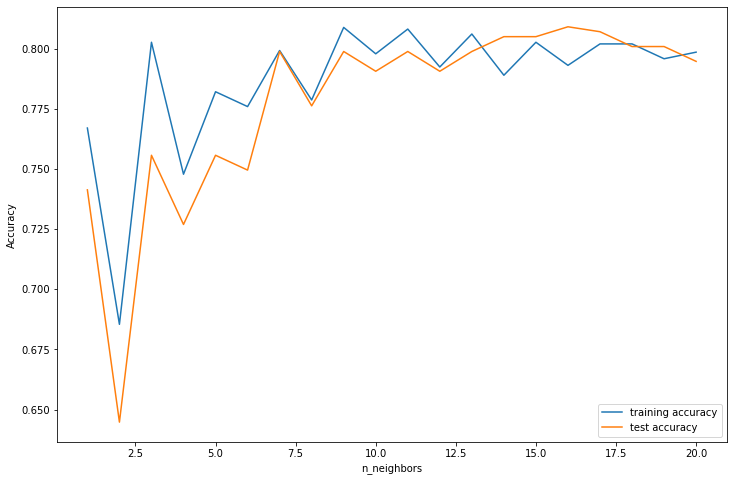

The optimal number of neighbors is: 16

K-Nearest Neighbors
-------------------------------
KNN Training Score  : 79.44
KNN Testing  Score  : 82.05
KNN Train-Test Gap  :  2.6099999999999994
KNN AUC Score       : 70.89999999999999

PT True Negatives   : 24
PT False Positives  : 26
PT False Negatives  : 9
PT True Positives   : 136

KNN Accuracy        : 82.05
KNN Precision       : 85.0
KNN Recall          : 93.78999999999999
KNN Specificity     : 48.0



In [82]:
#K-NEAREST NEIGHBORS
#defining the optimal neighbors
opt_neighbors = optimal_neighbors(x_data        = got_features,
                                  y_data        = got_target,
                                  response_type = 'class')

#instantiating scaler
scaler = StandardScaler()

#fitting the data
scaler.fit(got_features)

#transforming the data
x_scaled = scaler.transform(got_features)

#converting to a dataframe
x_scaled_df = pd.DataFrame(x_scaled)

#divinding scaled data into train and test
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    x_scaled_df,
    got_target,
    random_state = 219,
    test_size = 0.1,
    stratify = got_target)

#instantiating KNN Classification Model with Optimal Neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)

# fitting the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)


#saving scoring data for dynamic string
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)*100 # accuracy
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)*100
knn_gap         = abs(knn_train_score - knn_test_score)
knn_auc         = roc_auc_score(y_true  = y_test_scaled, y_score = knn_pred).round(decimals = 4)*100

#printing scores
print("""
K-Nearest Neighbors
-------------------------------""")
print('KNN Training Score  :', knn_train_score)
print('KNN Testing  Score  :', knn_test_score)
print('KNN Train-Test Gap  : ', knn_gap)
print('KNN AUC Score       :', knn_auc)

#unpacking and printing the confusion matrix
knn_tn,\
knn_fp,\
knn_fn,\
knn_tp = confusion_matrix(y_true = y_test_scaled, y_pred = knn_pred).ravel()

print(f"""
PT True Negatives   : {knn_tn}
PT False Positives  : {knn_fp}
PT False Negatives  : {knn_fn}
PT True Positives   : {knn_tp}""")

#saving the model's metrics
knn_acc = ((knn_tp + knn_tn)/(knn_tp + knn_fp + knn_fn + knn_tn)).round(decimals = 4)*100
knn_pre = (knn_tp / (knn_tp + knn_tn)).round(decimals = 4)*100
knn_rec = (knn_tp / (knn_tp + knn_fn)).round(decimals = 4)*100
knn_spe = (knn_tn / (knn_tn + knn_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
KNN Accuracy        : {knn_acc}
KNN Precision       : {knn_pre}
KNN Recall          : {knn_rec}
KNN Specificity     : {knn_spe}
""")

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>RANDOM FOREST</h4>
<br>

In [83]:
#RANDOM FOREST

#instantiating a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

#fitting the training data
rf_default_fit = rf_default.fit(x_train, y_train)


#predicting based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)

#saving scores
rf_train_score = rf_default_fit.score(x_train, y_train).round(4)*100
rf_test_score  = rf_default_fit.score(x_test, y_test).round(4)*100
rf_gap         = abs(rf_train_score - rf_test_score).round(4)
rf_auc   = roc_auc_score(y_true = y_test, y_score = rf_default_fit_pred).round(4)*100

#printing scores
print('RF Training Score  :', rf_train_score)
print('RF Testing  Score  :', rf_test_score)
print('RF Train-Test Gap  :', rf_gap)
print('RF AUC Score       :', rf_auc)

#unpacking and printing the confusion matrix
rf_tn,\
rf_fp,\
rf_fn,\
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()

print(f"""
RF True Negatives  : {rf_tn}
RF False Positives : {rf_fp}
RF False Negatives : {rf_fn}
RF True Positives  : {rf_tp}""")

#saving the model's metrics
rf_acc = ((rf_tp + rf_tn)/(rf_tp + rf_fp + rf_fn + rf_tn)).round(decimals = 4)*100
rf_pre = (rf_tp / (rf_tp + rf_tn)).round(decimals = 4)*100
rf_rec = (rf_tp / (rf_tp + rf_fn)).round(decimals = 4)*100
rf_spe = (rf_tn / (rf_tn + rf_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
RF Accuracy        : , {rf_acc}
RF Precision       : , {rf_pre}
RF Recall          : , {rf_rec}
RF Specificity     : , {rf_spe}
""")

RF Training Score  : 81.89999999999999
RF Testing  Score  : 84.61999999999999
RF Train-Test Gap  : 2.72
RF AUC Score       : 73.92999999999999

RF True Negatives  : 26
RF False Positives : 24
RF False Negatives : 6
RF True Positives  : 139

RF Accuracy        : , 84.61999999999999
RF Precision       : , 84.24000000000001
RF Recall          : , 95.86
RF Specificity     : , 52.0



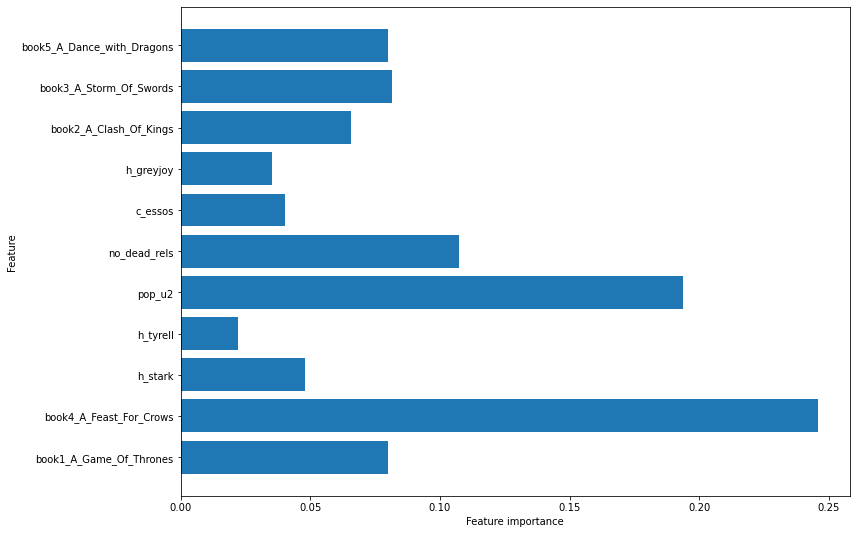

In [84]:
plot_feature_importances(rf_default_fit,
                         train = x_train,
                         export = False)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>RANDOM FOREST - TUNED</h4>
<br>We will now be using the hyperparameter tuning on the model.
<br>
<br>Bear in mind the hyperparameter code will be commented out due to the 240-second time limit.

In [85]:
# #RANDOM FOREST TUNED

# #fitting the training data
# rf_default_fit = rf_default.fit(x_train, y_train)

# #predicting based on the test set
# rf_default_fit_pred = rf_default_fit.predict(x_test)

# #declaring hyperparameter ranges
# estimator_range  = np.arange(100, 1000, 100)
# leaf_range       = np.arange(10, 31, 1)
# criterion_range  = ['gini', 'entropy']
# bootstrap_range  = [True, False]
# warm_start_range = [True, False]

# #establishing the hyperparameter grid
# param_grid = {'n_estimators'     : estimator_range,
#               'min_samples_leaf' : leaf_range,
#               'criterion'        : criterion_range,
#               'bootstrap'        : bootstrap_range,
#               'warm_start'       : warm_start_range}

# #instantiating the object model without hyperparameters
# forest_grid = RandomForestClassifier(random_state = 219)

# #declaring the GridSearch CV object
# forest_cv = RandomizedSearchCV(estimator           = forest_grid,
#                                param_distributions = param_grid,
#                                cv         = 3,
#                                n_iter     = 1000,
#                                scoring    = make_scorer(roc_auc_score,
#                                             needs_threshold = False))

# #fitting to the full dataset - no need to divide due to cross validation
# forest_cv.fit(got_features, got_target)

# #printing optimal parameters
# print("Tuned Parameters   : ", forest_cv.best_params_)
# print("Tuned Training AUC : ", forest_cv.best_score_.round(4))

In [86]:
#RANDOM FOREST - TUNED

#instantiating a random forest model with tuned values
rf_tuned = RandomForestClassifier(n_estimators       = 500,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 10,
                                    bootstrap        = False,
                                    warm_start       = True,
                                    random_state     = 219)

#fitting the training data
rf_tuned_fit = rf_tuned.fit(x_train, y_train)


#predicting based on the testing set
rf_tuned_fit_pred = rf_tuned_fit.predict(x_test)

#saving scores
rft_train_score = rf_tuned_fit.score(x_train, y_train).round(4)*100
rft_test_score  = rf_tuned_fit.score(x_test, y_test).round(4)*100
rft_gap         = abs(rft_train_score - rft_test_score).round(4)
rft_auc         = roc_auc_score(y_true = y_test, y_score = rf_tuned_fit_pred).round(4)*100

#printing scores
print('RFT Training Score :', rft_train_score)
print('RFT Testing  Score :', rft_test_score)
print('RFT Train-Test Gap :', rft_gap)
print('RFT AUC Score      :', rft_auc)

#unpacking and printing the confusion matrix
rft_tn,\
rft_fp,\
rft_fn,\
rft_tp = confusion_matrix(y_true = y_test, y_pred = rf_tuned_fit_pred).ravel()

print(f"""
RFT True Negatives  : {rft_tn}
RFT False Positives : {rft_fp}
RFT False Negatives : {rft_fn}
RFT True Positives  : {rft_tp}""")

#saving the model's metrics
rft_acc = ((rft_tp + rft_tn)/(rft_tp + rft_fp + rft_fn + rft_tn)).round(decimals = 4)*100
rft_pre = (rft_tp / (rft_tp + rft_tn)).round(decimals = 4)*100
rft_rec = (rft_tp / (rft_tp + rft_fn)).round(decimals = 4)*100
rft_spe = (rft_tn / (rft_tn + rft_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
RFT Accuracy    : , {rft_acc}
RFT Precision   : , {rft_pre}
RFT Recall      : , {rft_rec}
RFT Specificity : , {rft_spe}
""")

RFT Training Score : 79.95
RFT Testing  Score : 85.64
RFT Train-Test Gap : 5.69
RFT AUC Score      : 75.92999999999999

RFT True Negatives  : 28
RFT False Positives : 22
RFT False Negatives : 6
RFT True Positives  : 139

RFT Accuracy    : , 85.64
RFT Precision   : , 83.23
RFT Recall      : , 95.86
RFT Specificity : , 56.00000000000001



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>GRADIENT BOOSTED MACHINES</h4>

In [87]:
#instantiating the model object without hyperparameters
full_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)


#fitting to the train data
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


#predicting based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)

#saving scores
gbm_train_score = full_gbm_default_fit.score(x_train, y_train).round(4)*100
gbm_test_score  = full_gbm_default_fit.score(x_test, y_test).round(4)*100
gbm_gap         = abs(gbm_train_score - gbm_test_score).round(4)
gbm_auc         = roc_auc_score(y_true = y_test, y_score = full_gbm_default_pred).round(4)*100

#printing scores
print('GBM Training Score :', gbm_train_score)
print('GBM Testing  Score :', gbm_test_score)
print('GBM Train-Test Gap :', gbm_gap)
print('GBM AUC Score      :', gbm_auc)

#unpacking and printing the confusion matrix
gbm_tn,\
gbm_fp,\
gbm_fn,\
gbm_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_default_pred).ravel()

print(f"""
GBM True Negatives  : {gbm_tn}
GBM False Positives : {gbm_fp}
GBM False Negatives : {gbm_fn}
GBM True Positives  : {gbm_tp}""")

#saving the model's metrics
gbm_acc = ((gbm_tp + gbm_tn)/(gbm_tp + gbm_fp + gbm_fn + gbm_tn)).round(decimals = 4)*100
gbm_pre = (gbm_tp / (gbm_tp + gbm_tn)).round(decimals = 4)*100
gbm_rec = (gbm_tp / (gbm_tp + gbm_fn)).round(decimals = 4)*100
gbm_spe = (gbm_tn / (gbm_tn + gbm_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
GBM Accuracy    : , {gbm_acc}
GBM Precision   : , {gbm_pre}
GBM Recall      : , {gbm_rec}
GBM Specificity : , {gbm_spe}
""")

GBM Training Score : 80.64
GBM Testing  Score : 84.1
GBM Train-Test Gap : 3.46
GBM AUC Score      : 74.9

GBM True Negatives  : 28
GBM False Positives : 22
GBM False Negatives : 9
GBM True Positives  : 136

GBM Accuracy    : , 84.1
GBM Precision   : , 82.93
GBM Recall      : , 93.78999999999999
GBM Specificity : , 56.00000000000001



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h4>GRADIENT BOOSTED MACHINES - TUNED</h4>
<br>We will now be using the hyperparameter tuning on the model.
<br>
<br>Bear in mind the hyperparameter code will be commented out due to the 240-second time limit.

In [88]:
# # declaring a hyperparameter space
# learn_range        = np.arange(0.1, 2.5, 0.5)
# estimator_range    = np.arange(100, 501, 25)
# depth_range        = np.arange(2, 8, 1)
# warm_start_range   = [True, False]
# criterion_rang     = ['friedman_mse', 'squared_error', 'mse', 'mae']

# # creating a hyperparameter grid
# param_grid = {'learning_rate' : learn_range,
#               'max_depth'     : depth_range,
#               'n_estimators'  : estimator_range,
#               'warm_start'    : warm_start_range}


# # INSTANTIATING the model object without hyperparameters
# full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# # GridSearchCV object
# full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
#                            param_distributions = param_grid,
#                            cv                  = 3,
#                            n_iter              = 500,
#                            random_state        = 219,
#                            scoring             = make_scorer(roc_auc_score,
#                                                  needs_threshold = False))


# #fitting to the FULL DATASET (due to cross-validation)
# full_gbm_cv.fit(got_features, got_target)

# # printing the optimal parameters and best score
# print("Tuned Parameters  :", full_gbm_cv.best_params_)
# print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

In [89]:
#instantiating the model object without hyperparameters
full_gbm_tuned = GradientBoostingClassifier(learning_rate = 1.1,
                                              n_estimators  = 500,
                                              criterion     ='friedman_mse',
                                              max_depth     = 7,
                                              warm_start    = False,
                                              random_state  = 219)


#fitting to the train data
full_gbm_tuned_fit = full_gbm_default.fit(x_train, y_train)

#predicting based on the testing set
full_gbm_tuned_pred = full_gbm_default_fit.predict(x_test)

#saving scores
gbmt_train_score = full_gbm_tuned_fit.score(x_train, y_train).round(4)*100
gbmt_test_score  = full_gbm_tuned_fit.score(x_test, y_test).round(4)*100
gbmt_gap         = abs(gbm_train_score - gbm_test_score).round(4)
gbmt_auc         = roc_auc_score(y_true = y_test, y_score = full_gbm_tuned_pred).round(4)*100

#printing scores
print('GBMT Training Score :', gbmt_train_score)
print('GBMT Testing  Score :', gbmt_test_score)
print('GBMT Train-Test Gap :', gbmt_gap)
print('GBMT AUC Score      :', gbmt_auc)

#unpacking and printing the confusion matrix
gbmt_tn,\
gbmt_fp,\
gbmt_fn,\
gbmt_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_tuned_pred).ravel()

print(f"""
GBMT True Negatives  : {gbmt_tn}
GBMT False Positives : {gbmt_fp}
GBMT False Negatives : {gbmt_fn}
GBMT True Positives  : {gbmt_tp}""")

#saving the model's metrics
gbmt_acc = ((gbmt_tp + gbmt_tn)/(gbmt_tp + gbmt_fp + gbmt_fn + gbmt_tn)).round(decimals = 4)*100
gbmt_pre = (gbmt_tp / (gbmt_tp + gbmt_tn)).round(decimals = 4)*100
gbmt_rec = (gbmt_tp / (gbmt_tp + gbmt_fn)).round(decimals = 4)*100
gbmt_spe = (gbmt_tn / (gbmt_tn + gbmt_fp)).round(decimals = 4)*100

#printing the model's metrics
print(f"""
GBMT Accuracy    : , {gbmt_acc}
GBMT Precision   : , {gbmt_pre}
GBMT Recall      : , {gbmt_rec}
GBMT Specificity : , {gbmt_spe}
""")

GBMT Training Score : 80.64
GBMT Testing  Score : 84.1
GBMT Train-Test Gap : 3.46
GBMT AUC Score      : 74.9

GBMT True Negatives  : 28
GBMT False Positives : 22
GBMT False Negatives : 9
GBMT True Positives  : 136

GBMT Accuracy    : , 84.1
GBMT Precision   : , 82.93
GBMT Recall      : , 93.78999999999999
GBMT Specificity : , 56.00000000000001



<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>RESULTS AND MODEL SELECTION</h2>
<br>Let's compare the results of our different models and select the best one.

In [90]:
#comparing results
print(f"""
Model                 Train Score         Test Score             AUC Score           TN, FP, FN, TP          
-----                 --------------      -------------       ---------           --------------
Logistic Reg          {lr_train_score}               {lr_test_score}             {lr_auc}              {lr_tn, lr_fp, lr_fn, lr_tp} 
Logistic Reg - Tuned  {lrt_train_score}               {lrt_test_score}             {lrt_auc}              {lrt_tn, lrt_fp, lrt_fn, lrt_tp}
Pruned Tree           {pt_train_score}  {pt_test_score}             {pt_auc}              {pt_tn, pt_fp, pt_fn, pt_tp}
Pruned Tree - Tuned   {ptt_train_score}  {ptt_test_score}             {ptt_auc}              {ptt_tn, ptt_fp, ptt_fn, ptt_tp}
K-Nearest Neighbors   {knn_train_score}              {knn_test_score}             {knn_auc}  {knn_tn, knn_fp, knn_fn, knn_tp}
Random Forest         {rf_train_score}  {rf_test_score} {rf_auc}  {rf_tn, rf_fp, rf_fn, rf_tp}
Random Forest Tuned   {rft_train_score}              {rft_test_score}             {rft_auc}  {rft_tn, rft_fp, rft_fn, rft_tp}
GBM                   {gbm_train_score}              {gbm_test_score}              {gbm_auc}               {gbm_tn, gbm_fp, gbm_fn, gbm_tp}
GBM - Tuned           {gbmt_train_score}              {gbmt_test_score}              {gbmt_auc}               {gbmt_tn, gbmt_fp, gbmt_fn, gbmt_tp}

My Final Model is:
""")
#printing scores
print("""Pruned Tree - Tuned
-------------------------------""")
print('PTT Training Score  :', ptt_train_score)
print('PTT Testing  Score  :', ptt_test_score)
print('PTT Train-Test Gap  : ', ptt_gap)
print('PTT AUC Score       :', ptt_auc)

#printing confusion matrix
print(f"""
PTT True Negatives  : {ptt_tn}
PTT False Positives : {ptt_fp}
PTT False Negatives : {ptt_fn}
PTT True Positives  : {ptt_tp}""")

#printing the model's metrics
print(f"""
PTT Accuracy        : {ptt_acc}
PTT Precision       : {ptt_pre}
PTT Recall          : {ptt_rec}
PTT Specificity     : {ptt_spe}
""")


Model                 Train Score         Test Score             AUC Score           TN, FP, FN, TP          
-----                 --------------      -------------       ---------           --------------
Logistic Reg          79.5               81.54             72.52              (27, 23, 13, 132) 
Logistic Reg - Tuned  79.5               81.54             72.52              (27, 23, 13, 132)
Pruned Tree           79.21000000000001  85.64             77.24              (30, 20, 8, 137)
Pruned Tree - Tuned   80.17999999999999  83.59             77.83              (33, 17, 15, 130)
K-Nearest Neighbors   79.44              82.05             70.89999999999999  (24, 26, 9, 136)
Random Forest         81.89999999999999  84.61999999999999 73.92999999999999  (26, 24, 6, 139)
Random Forest Tuned   79.95              85.64             75.92999999999999  (28, 22, 6, 139)
GBM                   80.64              84.1              74.9               (28, 22, 9, 136)
GBM - Tuned           80.64 